In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torchvision
import torch.nn as nn
import os
import numpy as np
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
from torch import optim
import matplotlib.pyplot as plt
import math
import copy
warnings.filterwarnings('ignore')

In [11]:
INPUT_DIR='/content/drive/MyDrive/DSAIL/ml-100k/'
OUTPUT_DIR='/content/drive/MyDrive/DSAIL/ml-100k/'

#ratings = pd.read_csv(os.path.join(INPUT_DIR, 'u.data'),sep='\t', names = ["userId", "movieId", "rating", "timestamp"])
ratings = pd.read_csv(INPUT_DIR + 'u.data', sep='\t', names = ["userId", "movieId", "rating", "timestamp"])
movies = pd.read_csv(INPUT_DIR + 'u.item', sep="|", names = ['movieId', 'title', 'release_date', 'video_release_date', 'imdb_url', 'unknown', 'action', 'adventure',
                      'animation', 'children', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'film_noir', 'horror',
                      'musical', 'mystery', 'romance', 'sci_fi', 'thriller', 'war', 'western'], encoding="ISO-8859-1")
users = pd.read_csv(INPUT_DIR + 'u.user', sep="|", names = ['userId', 'age', 'gender', 'occupation', 'zip_code'])

ratings = ratings.drop('timestamp',axis=1)

users = users.drop('zip_code', axis=1)


movies = movies.drop('imdb_url', axis=1)
movies = movies.drop('video_release_date',axis=1)
movies = movies.fillna("1997")
movies["year"] = movies["release_date"].str[-4:].astype(int)
movies = movies.drop('release_date', axis=1)
movies = movies.drop('title', axis=1)

In [12]:
#dataloader한테 먹일 때 numpy를 해야한다. dataframe넣으면 오류가 난다.

one_hot = pd.get_dummies(ratings,columns = ratings.columns)
y = ratings['rating']
one_hot = one_hot.drop(columns = ['rating_1','rating_2','rating_3','rating_4','rating_5'])
one_hot = one_hot
one_hot = one_hot.to_numpy()
y = y.to_numpy()

In [13]:
x_train, x_test, y_train, y_test = train_test_split(one_hot,y, test_size = 0.2, random_state=1440)

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [7]:
from torch.utils.data import Dataset, DataLoader

class TrainDataset(Dataset):
  def __init__(self,data,target):
    self.data = data
    self.target = target

  def __len__(self):
    return len(self.data)

  def __getitem__(self,idx):
    return self.data[idx], self.target[idx]


In [8]:
class FM(nn.Module):
  def __init__(self,n,k):
    super(FM,self).__init__()
    self.W0 = nn.Parameter(torch.randn(1))
    self.W = nn.Parameter(torch.randn(n))
    self.V = nn.Parameter(torch.randn(n,k))

  def forward(self, x):
    x = x.float()
    linear_term = self.W0 + torch.matmul(self.W,x)
    # x가 1 by n  / self.V n by k면
    # x 곱 V 하면 1 by k 가 나온다. 여기에 논문이 의도한 수식과 동일하게 나온다.
    t1 = (torch.matmul(x,self.V))**2
    t2 = torch.matmul(x**2, self.V**2)
    t = t1-t2
    interaction_term = torch.sum(t)*0.5
    return linear_term + interaction_term


Epoch    0/30 Train Cost : 70.5428 Test Cost : 0.6144
Epoch    1/30 Train Cost : 55.5553 Test Cost : 0.5916
Epoch    2/30 Train Cost : 44.0576 Test Cost : 0.5701
Epoch    3/30 Train Cost : 35.1252 Test Cost : 0.5511
Epoch    4/30 Train Cost : 28.1225 Test Cost : 0.5343
Epoch    5/30 Train Cost : 22.5925 Test Cost : 0.5195
Epoch    6/30 Train Cost : 18.2000 Test Cost : 0.5065
Epoch    7/30 Train Cost : 14.6943 Test Cost : 0.4950
Epoch    8/30 Train Cost : 11.8857 Test Cost : 0.4847
Epoch    9/30 Train Cost : 9.6283 Test Cost : 0.4757
Epoch   10/30 Train Cost : 7.8094 Test Cost : 0.4676
Epoch   11/30 Train Cost : 6.3406 Test Cost : 0.4604
Epoch   12/30 Train Cost : 5.1525 Test Cost : 0.4540
Epoch   13/30 Train Cost : 4.1900 Test Cost : 0.4482
Epoch   14/30 Train Cost : 3.4094 Test Cost : 0.4431
Epoch   15/30 Train Cost : 2.7756 Test Cost : 0.4384
Epoch   16/30 Train Cost : 2.2607 Test Cost : 0.4342
Epoch   17/30 Train Cost : 1.8420 Test Cost : 0.4304
Epoch   18/30 Train Cost : 1.5013 Tes

Text(0.5, 1.0, 'MSE for validation set')

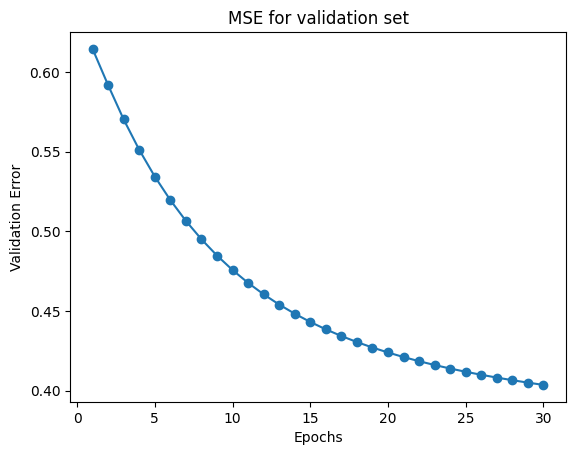

In [15]:
#우선 train dataset과 dataloader 정의 / test에도 마찬가지로 iterate가능하게끔 반복.
train_dataset = TrainDataset(x_train, y_train)
train_dataloader = DataLoader(x_train, 64, shuffle=False)

test_dataset = TrainDataset(x_test, y_test)
test_dataloader = DataLoader(x_test,64, shuffle=False)

#모델은 일단 클래스로 만들고, gpu에 넣을 수 있도록 to device까지
#optimizer 정의, lossfunction 정의
model = FM(n=x_train.shape[1],k=20)
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001)
loss_function = nn.MSELoss()
valid_loss = []

epochs = 30
for epoch in range(epochs):
  #model.train()
  for idx, batch in enumerate(train_dataloader):
    x_batch, y_batch = batch[0], batch[1]
    x_batch, y_batch = x_batch.cuda(), y_batch.cuda()

    #batch가져왔으면 예측하고 loss function 계산
    pred = model(x_batch)
    y_batch = y_batch.float()
    cost = loss_function(pred,y_batch)


    #누적되지 않게 zero grad 초기화/ 역전파/다음단계 넘어갈 준비
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()



  for idx, batch in enumerate(test_dataloader):
    x_batch, y_batch = batch[0], batch[1]
    x_batch, y_batch = x_batch.cuda(), y_batch.cuda()

    with torch.no_grad():
      pred_test = model(x_batch)
      y_batch_test = y_batch.float()
      cost_test = loss_function(pred_test,y_batch_test)
  valid_loss.append(cost_test.item())

  print('Epoch {:4d}/{} Train Cost : {:.4f} Test Cost : {:.4f}'.format(epoch, epochs, cost.item(), cost_test.item()))

plt.plot(range(1,epochs+1),valid_loss,marker='o')
plt.xlabel('Epochs')
plt.ylabel('Validation Error')
plt.title('MSE for validation set')
